In [1]:
import numpy as np
import pandas as pd
import glob
import os
import pathlib
from PIL import Image
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

%matplotlib inline

## 경로 설정

In [2]:
base_dir = '/opt/ml'
train_dir = '/opt/ml/input/data/train/'
eval_dir = '/opt/ml/input/data/eval/'

# CSV
train_csv = '/opt/ml/input/data/train/train.csv'
eval_csv = '/opt/ml/input/data/eval/info.csv'

# Image directory
train_image_dir = '/opt/ml/input/data/train/images/'
test_image_dir = '/opt/ml/input/data/eval/images/'

# train dataset
train_images_people = glob.glob('/opt/ml/input/data/train/images/*')   # train dataset 사람
train_images = glob.glob('/opt/ml/input/data/train/images/*/*')       # train dataset images

# test dataset
test_images = glob.glob('/opt/ml/input/data/eval/images/*.jpg')       # test dataset images

# 파일

In [3]:
print('폴더 이름')
pprint.pprint(train_images_people[:5])
print('*'*70)
print('각 폴더 내 사진 파일')
pprint.pprint(train_images[:7])

폴더 이름
['/opt/ml/input/data/train/images/006171_female_Asian_18',
 '/opt/ml/input/data/train/images/005521_female_Asian_50',
 '/opt/ml/input/data/train/images/006173_female_Asian_19',
 '/opt/ml/input/data/train/images/005271_male_Asian_20',
 '/opt/ml/input/data/train/images/000641_female_Asian_57']
**********************************************************************
각 폴더 내 사진 파일
['/opt/ml/input/data/train/images/006171_female_Asian_18/mask5.png',
 '/opt/ml/input/data/train/images/006171_female_Asian_18/mask3.png',
 '/opt/ml/input/data/train/images/006171_female_Asian_18/normal.png',
 '/opt/ml/input/data/train/images/006171_female_Asian_18/mask1.png',
 '/opt/ml/input/data/train/images/006171_female_Asian_18/mask4.png',
 '/opt/ml/input/data/train/images/006171_female_Asian_18/incorrect_mask.png',
 '/opt/ml/input/data/train/images/006171_female_Asian_18/mask2.png']


**Note**
* train data의 폴더 형식: 사람번호_성별_Asian_나이
* 폴더 내에 이미지 7장 있음
* 각 이미지는 마스크 **제대로 쓴 사진 5장, 안쓴 사진 1장, 마스크 불량하게 착용한 사진 1장**으로 구성

# 이미지

In [4]:
def get_file_extensions(path: List = None) -> List:
    '''file list에 있는 파일들의 확장자 추출'''
    ext_list = []
    for image in path:
        ext = pathlib.Path(image).suffix
        if ext not in ext_list:
            ext_list.append(ext)
    return ext_list

# file extensions
train_image_type = get_file_extensions(train_images)                  # train image data types
test_image_type = get_file_extensions(test_images)                    # test image data types

print('train dataset 사람 수: {}'.format(len(train_images_people)))
print('train dataset 이미지 수: {}'.format(len(train_images)))
print('train dataset 이미지 데이터 타입: {}'.format(train_image_type))
print('*'*70)
print('test dataset 사람 수: ?')
print('test datset 이미지 수: {}'.format(len(test_images)))
print('train dataset 이미지 데이터 타입: {}'.format(test_image_type))

train dataset 사람 수: 2700
train dataset 이미지 수: 18900
train dataset 이미지 데이터 타입: ['.png', '.jpg', '.jpeg']
**********************************************************************
test dataset 사람 수: ?
test datset 이미지 수: 12600
train dataset 이미지 데이터 타입: ['.jpg']


**Note**
* train data가 18900장으로 적다고 생각됨
* 데이터가 불균형 함. **imbalanced data** 어떻게 처리할지 고민 필요
* train data 확장자가 jpg, jpeg, png 3개이나 따로 신경쓰지 않아도 될듯함
* 12600 / 7 = 1800인걸로 보아 test dataset은 1800명의 이미지가 7장씩 있는걸로 추측됨

## 이미지 크기

In [5]:
# 모든 파일 이미지 사이즈 동일한지 확인
size = []
for image in train_images+test_images:
    image_size = Image.open(image).size
    if image_size not in size:
        size.append(image_size)
print('image_size :{}'.format(size))

image_size :[(384, 512)]


**Note**
* 이미지 사이즈는 모두 동일하게 (384, 512)

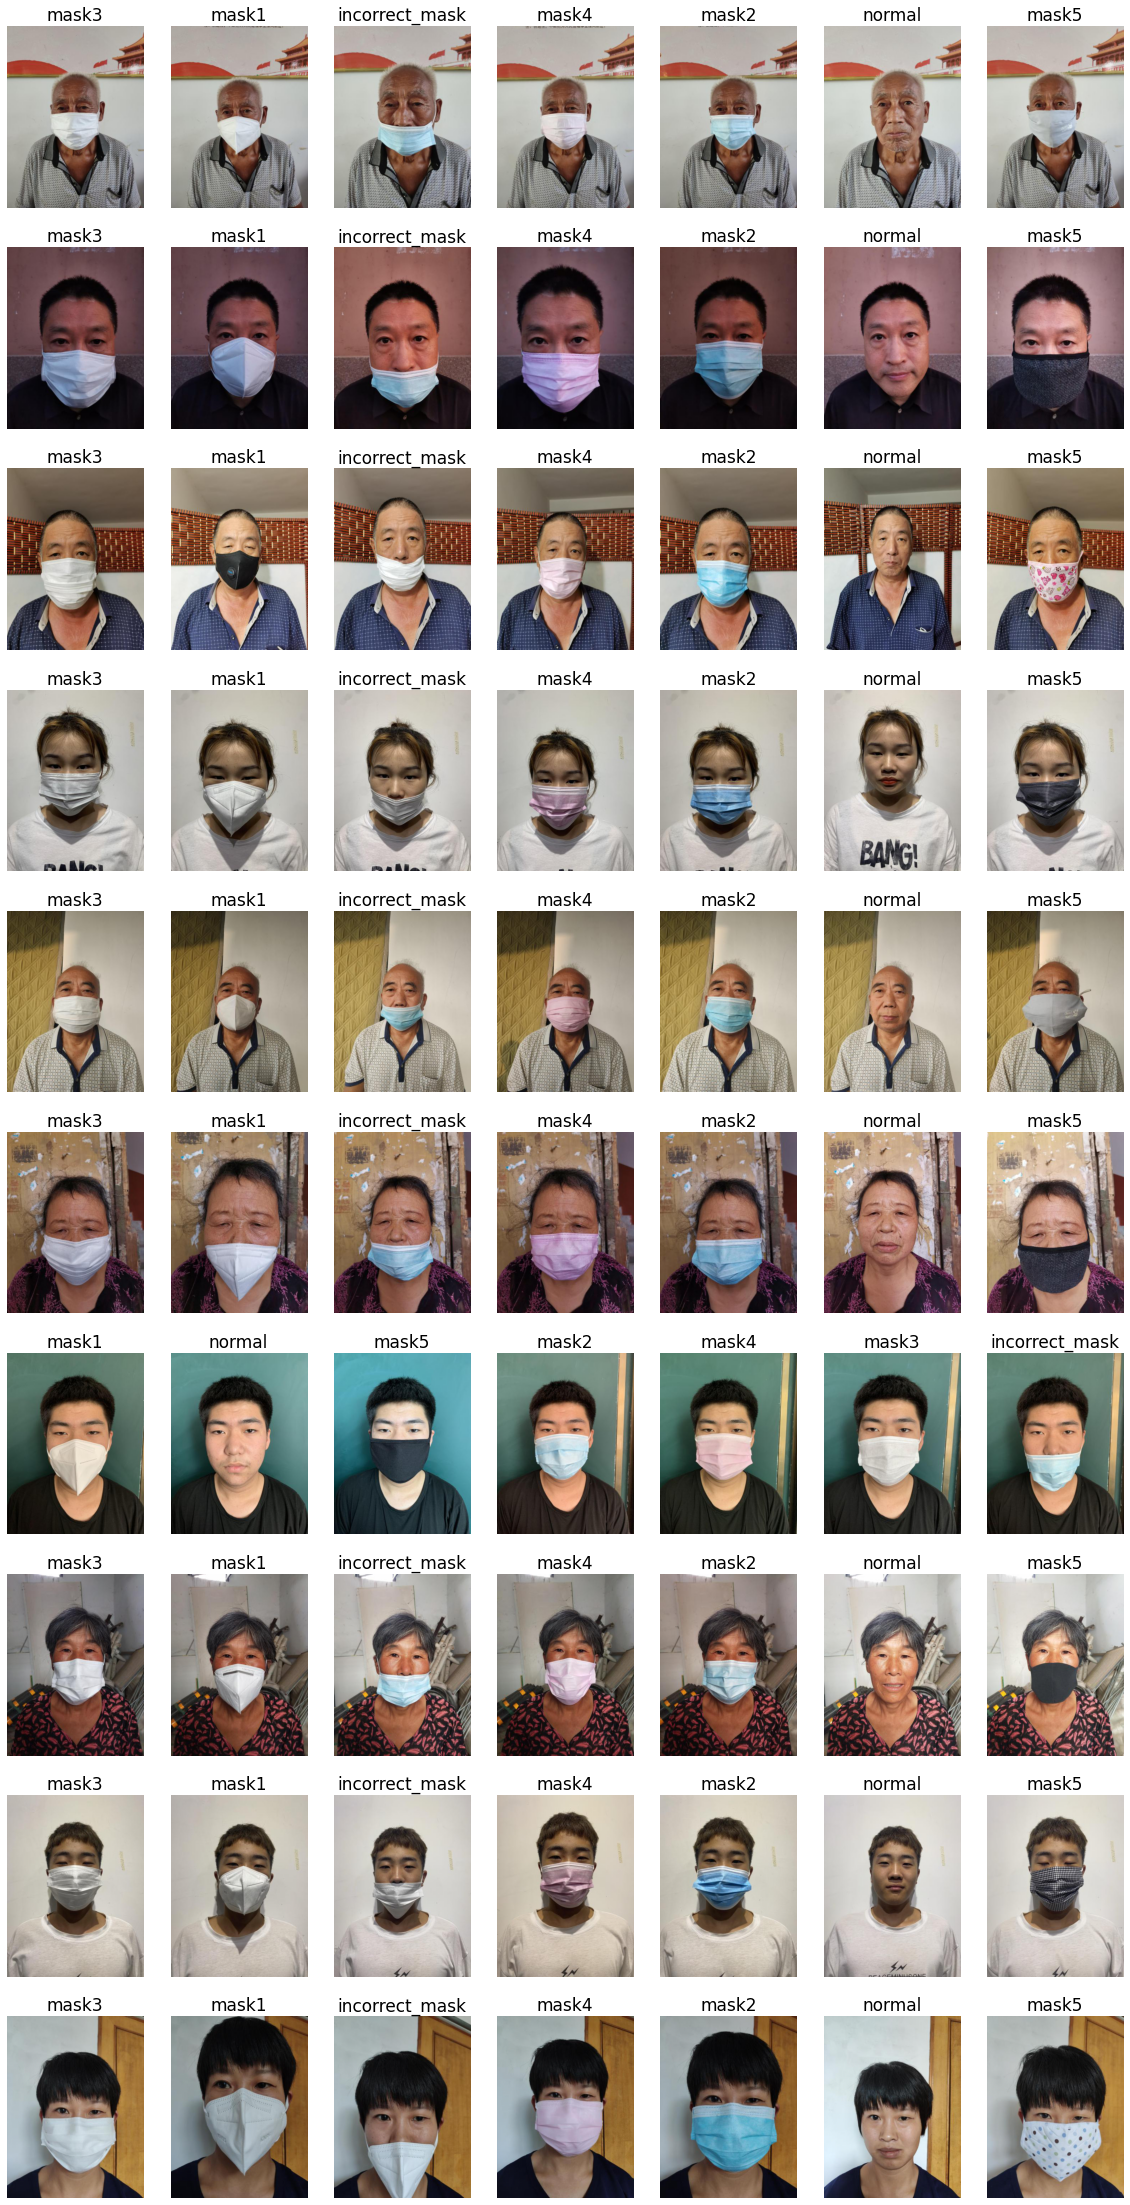

In [122]:
def plot_train_images(filepath: List = None, index: List = [1,2,3]) -> None:
    '''사람을 index로 받아 이미지 출력'''
    people = len(index)
    fig = plt.figure(figsize=(20,4*people))
    for i, idx in enumerate(range(7*people)):
        # label 추출
        image_path = train_images[idx] # image 경로
        label, _ = os.path.splitext(os.path.basename(image_path)) # label 구하기

        # 이미지 출력
        ax = fig.add_subplot(number_of_people, 7, i+1)
        ax.axis('off')
        ax.set_title(label, fontsize = 17)
        img = Image.open(image_path)
        plt.imshow(img)

plot_train_images(train_images, index=range(10))

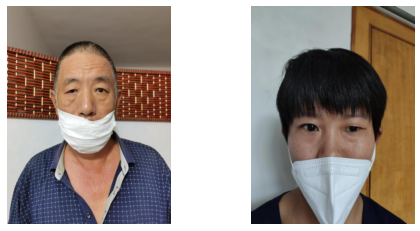

In [123]:
fig = plt.figure(figsize=(8,4))
img1 = train_images[16]
img2 = train_images[65]
for i, idx in enumerate([16,65]):
    ax = fig.add_subplot(1, 2, i+1)
    ax.axis('off')
    img = Image.open(train_images[idx])
    plt.imshow(img)

**Note**
* 같은 incorrect_mask로 label된 이미지이나 한 명은 콧구멍이 보이게, 한 명은 코끝을 가리게 마스크 씀
* 분류 모델이 구분하기 어려울지도?

## 클래스 분류

![image info](./class.png)

**Note**
* class 분류는 18개
* 마스크 착용여부, 성별, 나이에 따라 분류한 후 클래스 만든 것 (3*2*3)
* 모델 하나로 18개의 클래스를 분류하는 것보다 각각의 분류 모델을 따로 만든 후 클래스를 예측하는게 정확도가 좋을듯?
* 한 번에 하면 18900장으로 18개의 클래스를 분류하는거지만, 따로 따로 하면 18900장으로 클래스 3개, 2개만 분류하는 것이라 trainig이 더 잘 될 것으로 예상

# 데이터 분포

In [6]:
train_data_info = pd.read_csv(train_csv)

In [7]:
train_data_info.head(10)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
5,000007,female,Asian,58,000007_female_Asian_58
6,000008,female,Asian,58,000008_female_Asian_58
7,000009,female,Asian,56,000009_female_Asian_56
8,000010,female,Asian,58,000010_female_Asian_58
9,000012,male,Asian,57,000012_male_Asian_57


In [8]:
print(sorted(train_data_info['age'].unique()))

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


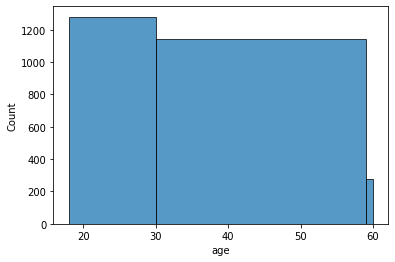

In [9]:
sns.histplot(train_data_info, x='age', bins=[18,30,59,60])
plt.show()


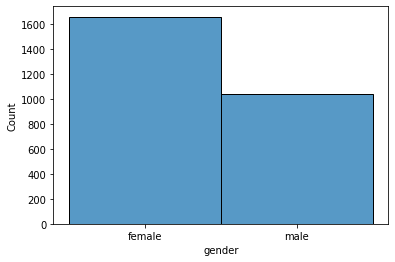

gender
female    1658
male      1042
dtype: int64


In [10]:
sns.histplot(train_data_info, x='gender')
plt.show()
print(train_data_info.groupby('gender').size())

In [12]:
label = pd.read_csv('label.csv')
label.head()

,path,mask_label,gender_label,age_label,label
0,/opt/ml/input/data/train/images/006171_female_...,0,1,0,3
1,/opt/ml/input/data/train/images/006171_female_...,0,1,0,3
2,/opt/ml/input/data/train/images/006171_female_...,2,1,0,15
3,/opt/ml/input/data/train/images/006171_female_...,0,1,0,3
4,/opt/ml/input/data/train/images/006171_female_...,0,1,0,3


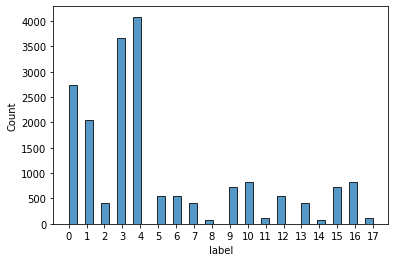

In [16]:
g = sns.histplot(label, x='label')
g.set_xticks(range(18))
plt.show()

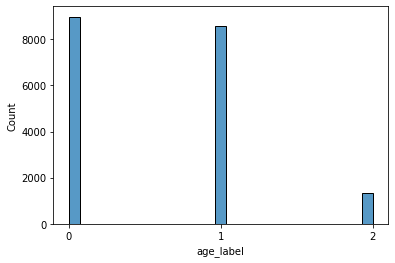

In [23]:
a = sns.histplot(label, x='age_label')
a.set_xticks([0,1,2])
plt.show()

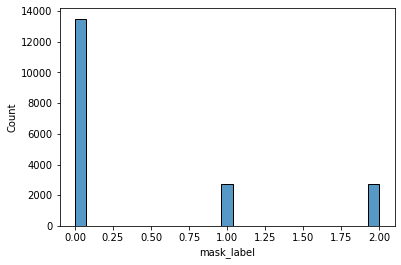

In [34]:
g = sns.histplot(label, x='mask_label')
# g.set_xticks(range(3))
plt.show()

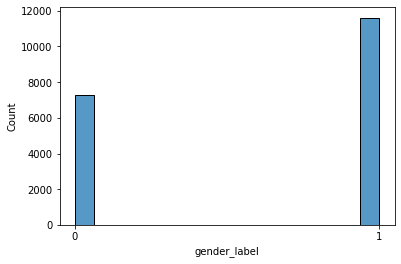

In [33]:
g = sns.histplot(label, x='gender_label')
g.set_xticks(range(2))

plt.show()